## Setup

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import pickle
from matplotlib.colors import Colormap

In [2]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, BayesianRidge
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from scipy.stats import entropy, gaussian_kde, pearsonr
from scipy.stats import entropy, gaussian_kde, pearsonr

In [11]:
data_path = '../data/Networld_N200_TMax10000/'

El conjunto de datos se carga como un diccionario sobre $\beta$ ya que en este caso se tienen que mantener separadas. Tomo solo las $\beta$ que no se reservaron como OOS en la etapa anterior para mantener la división de datos tan consistente como sea posible.

Técnicamente para el análisis exploratorio no haría falta pero como solo voy a explorar usando unas pocas $\beta$ pues ya que estamos cojo otras diferentes.

In [36]:
betas = [0.0015849,0.0025119,0.0039811,0.0063096,
         0.015849,0.025119,0.039811,0.063096,
         0.1,0.15849,0.25119,0.39811,
         1, 1.5849, 2.5119, 3.9811]

db = {beta: pd.read_csv(data_path + f'ABD_MEA_N200_K5_Beta{beta}.csv') 
        for beta in betas}

for beta, data in db.items():
        # Hay una o un par de redes con mu a nan y nos 
        # las quitamos para que no den error
        data = data.loc[~ data.isna().any(axis=1)]
        data['log(Size)'] = np.log10(data['Size'])
        data['log(Ab)'] = np.log10(data['Ab'])
        data['log(beta)'] = np.log10(data['beta'])
        db[beta] = data

        print(db[beta].head())

   NRed        Ab      beta  Size   Lambda1  Lambda2   mu  Gr_Medio         H  \
0     1  0.985471  0.001585     1  0.000000      0.0  0.0  0.000000  0.000000   
1     2  0.014508  0.001585     2  1.000000      1.0  2.0  1.000000  0.000000   
2    30  0.000021  0.001585     3  1.414214      0.0  1.0  1.333333  0.918296   

   log(Size)   log(Ab)  log(beta)  
0   0.000000 -0.006356  -2.799998  
1   0.301030 -1.838395  -2.799998  
2   0.477121 -4.683408  -2.799998  
   NRed            Ab      beta  Size   Lambda1   Lambda2        mu  Gr_Medio  \
0     1  9.771743e-01  0.002512     1  0.000000  0.000000  0.000000  0.000000   
1     2  2.277302e-02  0.002512     2  1.000000  1.000000  2.000000  1.000000   
2     3  6.071826e-07  0.002512     4  1.618034  0.618034  0.585786  1.500000   
3    20  1.278279e-07  0.002512     4  1.732051  0.000000  1.000000  1.500000   
4    30  5.189814e-05  0.002512     3  1.414214  0.000000  1.000000  1.333333   

          H  log(Size)   log(Ab)  log(beta) 

/tmp/ipykernel_9890/1557581038.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log(Size)'] = np.log10(data['Size'])
/tmp/ipykernel_9890/1557581038.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['log(Ab)'] = np.log10(data['Ab'])
/tmp/ipykernel_9890/1557581038.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

## Análisis exploratorio

Para continuar con la modelización omitir esto, era para no tener que cambiar el db que había estado usando todo el rato en el análisis exploratorio

In [8]:
db = {key:val for key,val in db.items()
      if key in [0.0015849, 0.015849, 0.1, 0.39811, 3.9811]}

### Distribuciones univariadas

***Variable Target***

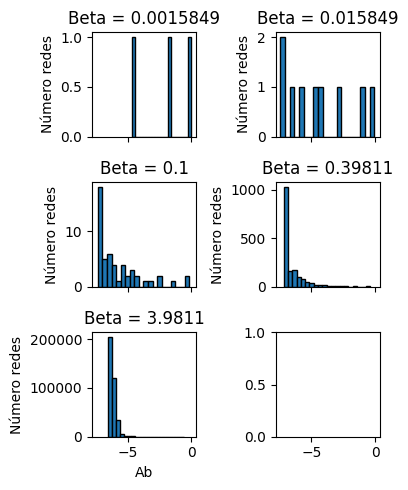

In [18]:
fig, axs = plt.subplots(3,2, figsize=(4,5), sharex='all')
axs = [ax for axlist in axs for ax in axlist]

for i,beta in enumerate(db.keys()):
    db[beta]['log(Ab)'].plot.hist(bins=20, edgecolor='black', ax=axs[i])
    axs[i].set_xlabel('Ab')
    #axs[i].set_yscale('log')
    axs[i].set_ylabel('Número redes')
    axs[i].set_title(f'Beta = {beta}')

fig.tight_layout()

La abundancia con $\beta$ grande sigue una distribución casi igual a la que se veía antes (las $\beta$ grandes dominan la distribución), pero podemos ver que hay una forma más o menos subyacente (una beta o lognormal?) que se va escorando y haciendo más extrema al subir $\beta$

***Variables predictoras***

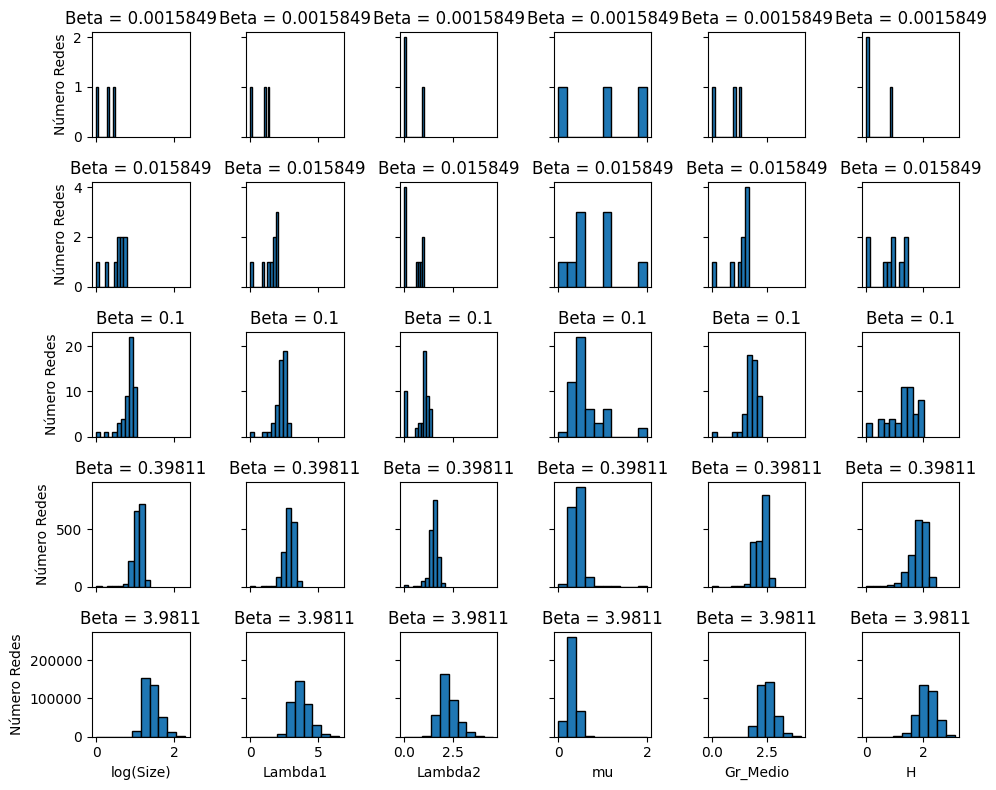

In [24]:
fig, axs = plt.subplots(5,6, figsize=(10,10), sharex='col', sharey='row')

for i,beta in enumerate(db.keys()):
    measures = db[beta][['NRed','log(Size)','Lambda1','Lambda2','mu','Gr_Medio','H']]
    for j,col in enumerate(measures.columns[1:]):
        measures[col].plot.hist(ax=axs[i][j], edgecolor='black')
        axs[i][j].set_xlabel(col)
        axs[i][j].set_ylabel('Número Redes')
        axs[i][j].set_title(f'Beta = {beta}')

fig.tight_layout()

Los predictores siguen más o menos las mismas distribuciones normales o casi normales de antes con la diferencia sobre todo de que van ganando estadistica y cambian un poco sus medias, etc. cuando sube $\beta$

### Distribuciones bivariadas

***Variable predictora - target***

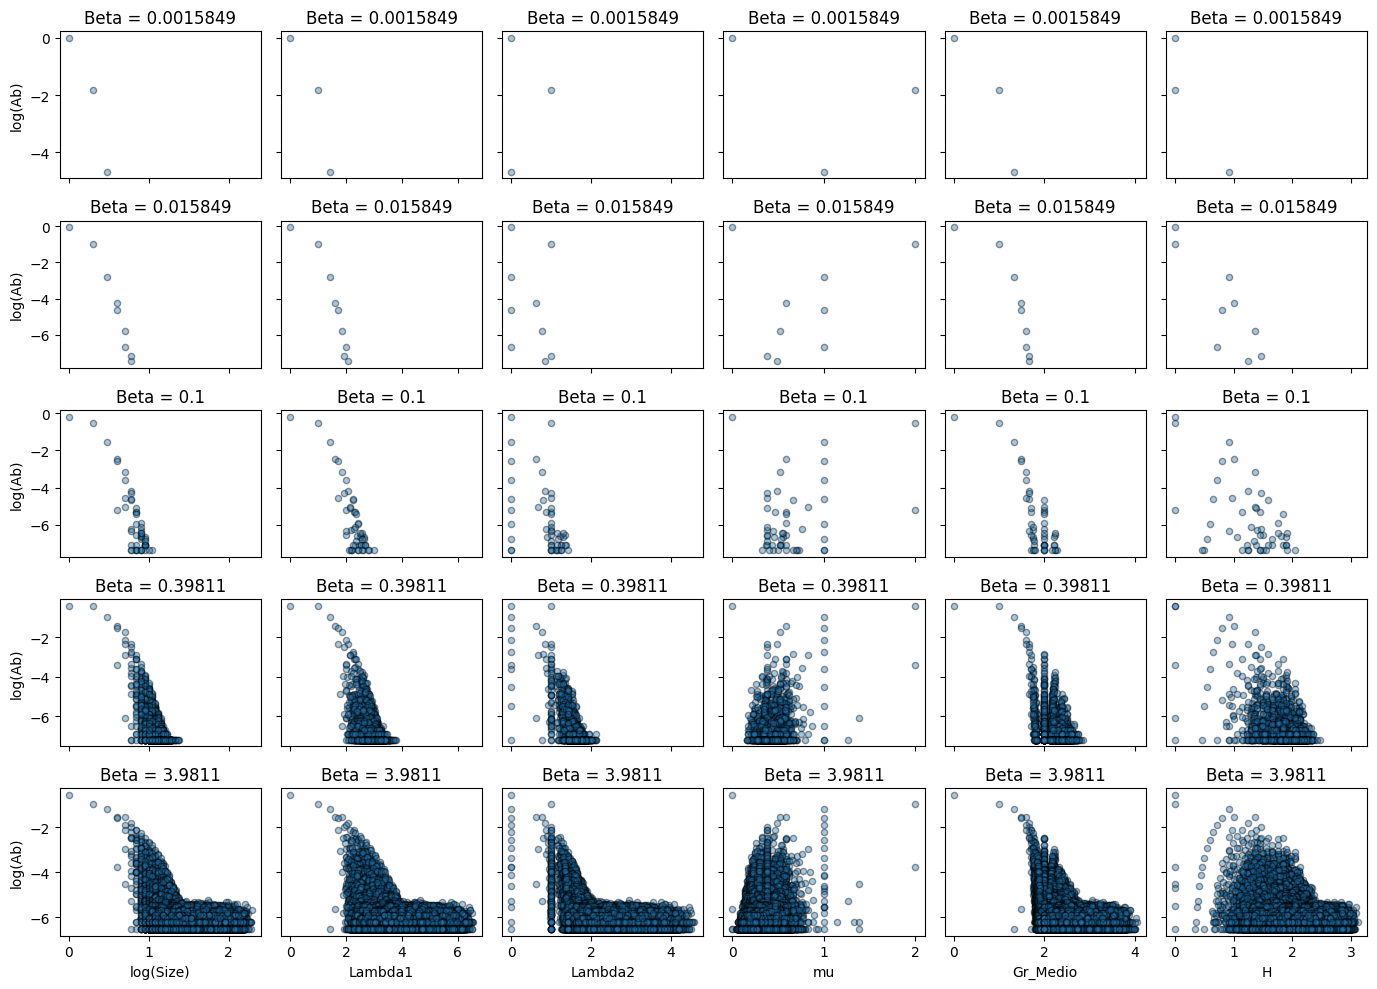

In [9]:
fig, axs = plt.subplots(5,6, figsize=(14,10), sharex='col', sharey='row')

meas_columns = ['log(Size)','Lambda1','Lambda2','mu','Gr_Medio','H']
for i,beta in enumerate(db.keys()):
    for j,col in enumerate(meas_columns):
        db[beta].plot.scatter(x=col, y='log(Ab)', alpha=0.4, edgecolor='black', ax=axs[i][j])
        axs[i][j].set_title(f'Beta = {beta}')
        axs[i][j].locator_params(axis='x', nbins=4)
fig.tight_layout()

Con $\beta$ baja se puede apreciar bastante bien porque se podría haber encontrado una relación lineal o casi lineal con la abundancia (u otras medidas). Pero según $\beta$ aumenta la relación se va degradando.

Esto puede ser un problema considerable porque apunta a que según aumente $\beta$ la relación será menos y menos clara, pero bueno nosotros de momento vamos a tirar para alante y a ver que tal, porque con la $\beta$ como predictora las cosas realmente no salieron ni tan mal

La distribución bivariada de predictores no cambia realmente frente a la que se vió en la etapa anterior porque las redes que hay son las mismas, y dentro de una misma $\beta$ en principio hay las mismas correlaciones / redundancias

### Predictibilidad conjunta

In [36]:
def compute_entropy(sample):
    if len(sample.unique()) > 1:
        kernel = gaussian_kde(sample)
        positions = np.linspace(-10,0,2000)
        densities = kernel(positions)
        return entropy(densities)
    else:
        return 0

***Distribución Size + $\mu$***


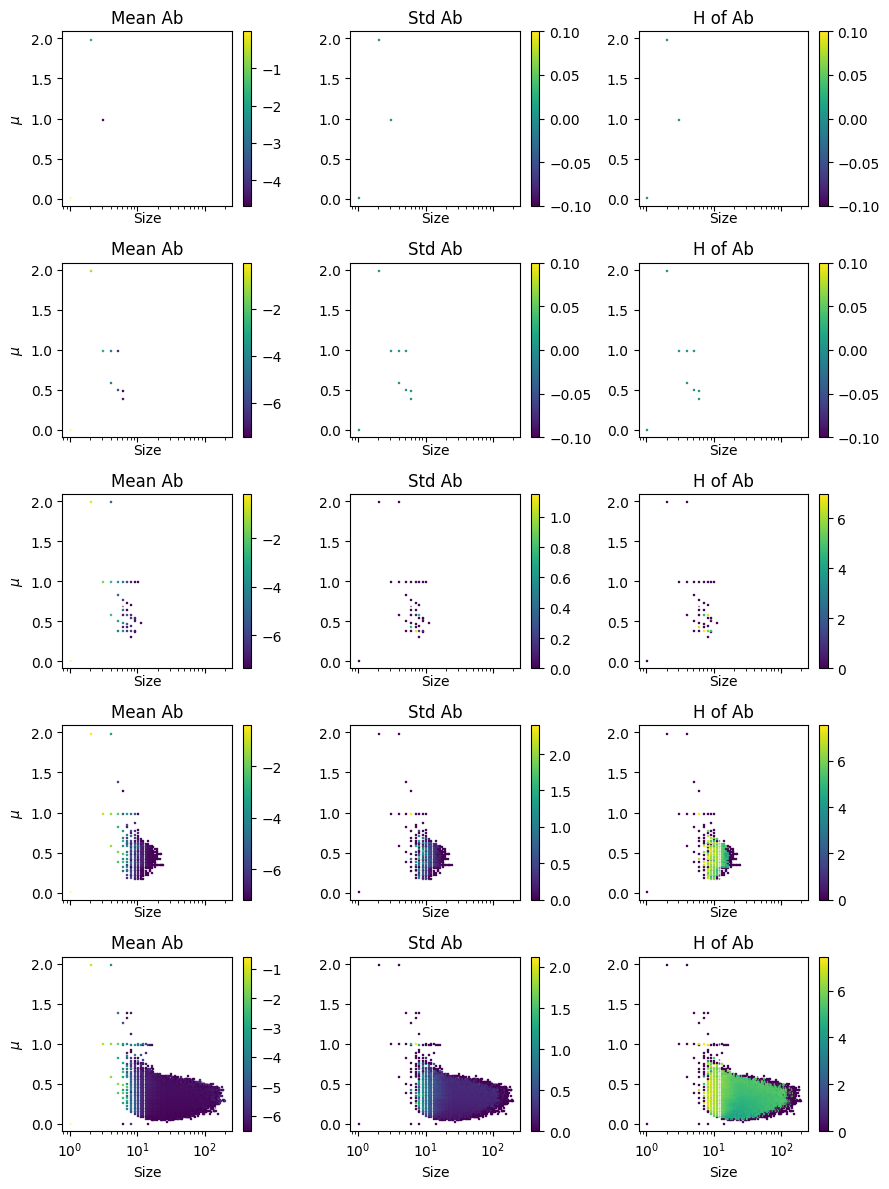

In [42]:
fig, axs = plt.subplots(5,3,figsize=(9,12), sharex='col')

for i,beta in enumerate(db.keys()):

    db[beta]['mu_disc'] = pd.cut(db[beta]['mu'], 100).apply(lambda x: x.mid)
    mean_ab = db[beta].groupby(['Size','mu_disc'])['log(Ab)'].mean().reset_index()
    std_ab = db[beta].groupby(['Size','mu_disc'], observed=True)['log(Ab)'].std().fillna(0).reset_index()
    h_ab = db[beta].groupby(['Size','mu_disc'], observed=True)['log(Ab)'].agg(compute_entropy).fillna(0).reset_index()

    im1 = axs[i][0].scatter(x=mean_ab['Size'], y=mean_ab['mu_disc'], c=mean_ab['log(Ab)'], s=0.5, marker='s')
    axs[i][0].set_xscale('log')
    axs[i][0].set_xlabel('Size')
    axs[i][0].set_ylabel(r'$\mu$')
    axs[i][0].set_title('Mean Ab')
    fig.colorbar(im1, ax=axs[i][0])
    im2 = axs[i][1].scatter(x=std_ab['Size'], y=std_ab['mu_disc'], c=std_ab['log(Ab)'], s=0.5, marker='s')
    axs[i][1].set_xscale('log')
    axs[i][1].set_xlabel('Size')
    axs[i][1].set_title('Std Ab')
    fig.colorbar(im2, ax=axs[i][1])
    im3 = axs[i][2].scatter(x=h_ab['Size'], y=h_ab['mu_disc'], c=h_ab['log(Ab)'], s=0.5, marker='s')
    axs[i][2].set_xscale('log')
    axs[i][2].set_xlabel('Size')
    axs[i][2].set_title('H of Ab')
    fig.colorbar(im3, ax=axs[i][2])

fig.tight_layout()

Para $\beta$ baja este plot se vuelve muy poco informativo por tener tan pocos puntos, pero con las 2 últimas líneas si se pueden ver algunas cosas algo interesantes. 

Posiblemente no sea muy diferente de lo que pasa solo al considerar el tamaño, pero hay una región importante donde la incertidumbre tampoco es demasiado alta. La zona de 10^1 de tamaño si está bastante jodidita tho.

## División de Datos



***Out-of-Sample (OOS)***

Ya está hecho, se han guardado las $\beta$ que no se han cargado al principio

***Training (TRN) and Test (TST)***

La división se hace dentro de cada $\beta$. Para los datos de cada $\beta$ se hace una división de train y test como se pueda según el número de redes que tiene (para $\beta$ bajo como se pueda va a ser tirando a malamente pero bueno)

In [38]:
db_train = {}
db_test = {}

for beta, data in db.items():
    data = data[['NRed','log(Ab)','beta', 'log(beta)','log(Size)','mu','Lambda1','Lambda2','Gr_Medio','H']]
    train, test = train_test_split(data, test_size=0.2)
    db_train[beta] = train
    db_test[beta] = test

del db

Para guardar la partición la juntamos en un dataframe y la dejamos como csv, durante la apertura la volveremos a parsear como un diccionario

In [39]:
table_train = pd.concat(db_train.values())
table_train.to_csv('../data/Networld_N200_TMax10000/TRN_MEAS_PARB.csv', index=False)
table_test = pd.concat(db_test.values())
table_test.to_csv('../data/Networld_N200_TMax10000/TST_MEAS_PARB.csv', index=False)

## Entrenamiento de Modelos

***Carga de datos***

Datos de entrenamiento

In [40]:
table_train = pd.read_csv('../data/Networld_N200_TMax10000/TRN_MEAS_PARB.csv')

db_Xtr = {}
db_nred_tr = {}
db_ytr = {}
for beta in table_train['beta'].unique():
    train = table_train.loc[table_train['beta'] == beta]
    db_Xtr[beta] = train[['log(Size)','mu','Lambda1','Lambda2','Gr_Medio','H']]
    db_nred_tr[beta] = train['NRed']
    db_ytr[beta] = train['log(Ab)']

del table_train

Muestreo uniforme de abundancias para representar graficos de correlación entre Ab predicha y Ab real. Hay que coger un set de indices para cada $\beta$

In [42]:
db_indexes = {}

for beta, ytr in db_ytr.items():
    abmin, abmax = ytr.min(), ytr.max()
    abs = np.random.uniform(low=abmin, high=abmax, size=(500,1))

    db_indexes[beta] = []
    for ab in abs:
        db_indexes[beta].append(np.argmin((ytr - ab).abs()))

Indices para la división por CV

In [43]:
db_kf = {}

for beta in db_Xtr.keys():
    n = len(db_Xtr[beta])
    nfolds = min(n, 5)
    db_kf[beta] = [idx_pair for idx_pair 
                in KFold(n_splits=nfolds).split(db_Xtr[beta], db_ytr[beta])]

***Peso de Ejemplos***

In [44]:
db_wtr = {}

for beta, ytr in db_ytr.items():
    kde = gaussian_kde(ytr)
    y_uniq = np.unique(ytr)
    wt_uniq = 1 / kde(y_uniq)

    replacement_table = { y:wt for y,wt in zip(y_uniq, wt_uniq) }

    db_wtr[beta] = ytr.replace(replacement_table)

with open('../data/Networld_N200_TMax10000/TRN_sample_weights_PARB.pkl', 'wb') as handle:
    pickle.dump(db_wtr, handle)

In [6]:
with open('../data/Networld_N200_TMax10000/TRN_sample_weights_PARB.pkl', 'rb') as handle:
    db_wtr = pickle.load(handle)

### Regresión Lineal Lasso

***Selección hiperparámetros***

Hacemos un grid search de $\alpha$ por separado para cada $\beta$

In [45]:
cv_results = { beta:[] for beta in db_Xtr.keys() }

In [48]:
for beta in db_Xtr.keys():
    print(f'Models for beta = {beta}')
    Xtr = db_Xtr[beta]
    ytr = db_ytr[beta]
    wtr = db_wtr[beta]

    alpha_grid = 10 ** np.arange(-3,3,0.5)

    cv_res = []
    for alpha in alpha_grid:
        pipe = Pipeline([('scaler', StandardScaler()), 
                            ('lr', Lasso(alpha=alpha))])
        scores = []
        for (fit_index, val_index) in db_kf[beta]:
            Xfit = Xtr.iloc[fit_index]
            yfit = ytr.iloc[fit_index]
            wtfit = wtr.iloc[fit_index]
            pipe.fit(Xfit, yfit, lr__sample_weight=wtfit)

            Xval = Xtr.iloc[val_index]
            yval = ytr.iloc[val_index]
            wtval = wtr.iloc[val_index]
            yp = pipe.predict(Xval)
            scores.append( mean_squared_error(yval, yp, sample_weight=wtval) )

        mean_score = np.mean(scores)
        std_score = np.std(scores)
        cv_res.append({'alpha': alpha, 'mean_score': mean_score, 'std_score': std_score})

        print(f'Alpha = {alpha}  -  Mean Score: {mean_score}')

    cv_results[beta] = pd.DataFrame(cv_res)

Models for beta = 0.0015849
Alpha = 0.001  -  Mean Score: 8.094096993607168
Alpha = 0.0031622776601683794  -  Mean Score: 8.094096993607168
Alpha = 0.01  -  Mean Score: 8.094096993607168
Alpha = 0.03162277660168379  -  Mean Score: 8.094096993607168
Alpha = 0.1  -  Mean Score: 8.094096993607168
Alpha = 0.31622776601683794  -  Mean Score: 8.094096993607168
Alpha = 1.0  -  Mean Score: 8.094096993607168
Alpha = 3.1622776601683795  -  Mean Score: 8.094096993607168
Alpha = 10.0  -  Mean Score: 8.094096993607168
Alpha = 31.622776601683793  -  Mean Score: 8.094096993607168
Alpha = 100.0  -  Mean Score: 8.094096993607168
Alpha = 316.22776601683796  -  Mean Score: 8.094096993607168
Models for beta = 0.0025119
Alpha = 0.001  -  Mean Score: 0.6711823406211233


/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.00

Alpha = 0.0031622776601683794  -  Mean Score: 0.5096493533114644
Alpha = 0.01  -  Mean Score: 0.4231375437878751
Alpha = 0.03162277660168379  -  Mean Score: 0.3301463291874107
Alpha = 0.1  -  Mean Score: 0.2698388663401636
Alpha = 0.31622776601683794  -  Mean Score: 0.46909131540693483
Alpha = 1.0  -  Mean Score: 4.2836212358517605
Alpha = 3.1622776601683795  -  Mean Score: 8.5021721146657


/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.965e-03, tolerance: 1.428e-03
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.200e-03, tolerance: 1.831e-03
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.65

Alpha = 10.0  -  Mean Score: 8.5021721146657
Alpha = 31.622776601683793  -  Mean Score: 8.5021721146657
Alpha = 100.0  -  Mean Score: 8.5021721146657
Alpha = 316.22776601683796  -  Mean Score: 8.5021721146657
Models for beta = 0.0039811
Alpha = 0.001  -  Mean Score: 0.7176787489268841
Alpha = 0.0031622776601683794  -  Mean Score: 0.6049107669553019
Alpha = 0.01  -  Mean Score: 0.5116517434153701


/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.827e-04, tolerance: 3.592e-04
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e-03, tolerance: 1.290e-03
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.79

Alpha = 0.03162277660168379  -  Mean Score: 0.39779660364713376
Alpha = 0.1  -  Mean Score: 0.3114508566651003
Alpha = 0.31622776601683794  -  Mean Score: 0.48612078643520656
Alpha = 1.0  -  Mean Score: 4.181153943279444
Alpha = 3.1622776601683795  -  Mean Score: 7.569059393251155
Alpha = 10.0  -  Mean Score: 7.569059393251155
Alpha = 31.622776601683793  -  Mean Score: 7.569059393251155
Alpha = 100.0  -  Mean Score: 7.569059393251155
Alpha = 316.22776601683796  -  Mean Score: 7.569059393251155
Models for beta = 0.0063096
Alpha = 0.001  -  Mean Score: 0.3673819154230909
Alpha = 0.0031622776601683794  -  Mean Score: 0.41088133179389985
Alpha = 0.01  -  Mean Score: 0.33865826552196054
Alpha = 0.03162277660168379  -  Mean Score: 0.26362709974564236
Alpha = 0.1  -  Mean Score: 0.2222478979551071
Alpha = 0.31622776601683794  -  Mean Score: 0.45233907778215743


/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.175e-04, tolerance: 2.921e-04
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e-03, tolerance: 1.061e-03
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.85

Alpha = 1.0  -  Mean Score: 4.329425599162483
Alpha = 3.1622776601683795  -  Mean Score: 6.336133350668694
Alpha = 10.0  -  Mean Score: 6.336133350668694
Alpha = 31.622776601683793  -  Mean Score: 6.336133350668694
Alpha = 100.0  -  Mean Score: 6.336133350668694
Alpha = 316.22776601683796  -  Mean Score: 6.336133350668694
Models for beta = 0.015849
Alpha = 0.001  -  Mean Score: 8.902079943580393
Alpha = 0.0031622776601683794  -  Mean Score: 8.453367957785366


/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e-02, tolerance: 3.359e-03
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e-02, tolerance: 3.721e-03
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.51

Alpha = 0.01  -  Mean Score: 8.053726258373022
Alpha = 0.03162277660168379  -  Mean Score: 6.696852109857476
Alpha = 0.1  -  Mean Score: 6.066082191684366
Alpha = 0.31622776601683794  -  Mean Score: 3.878121056508377
Alpha = 1.0  -  Mean Score: 1.7381779607356578
Alpha = 3.1622776601683795  -  Mean Score: 10.131033972292748
Alpha = 10.0  -  Mean Score: 10.144083950024234
Alpha = 31.622776601683793  -  Mean Score: 10.144083950024234
Alpha = 100.0  -  Mean Score: 10.144083950024234
Alpha = 316.22776601683796  -  Mean Score: 10.144083950024234
Models for beta = 0.025119
Alpha = 0.001  -  Mean Score: 0.8290612636846267
Alpha = 0.0031622776601683794  -  Mean Score: 0.782635389736181
Alpha = 0.01  -  Mean Score: 0.7737397207877506
Alpha = 0.03162277660168379  -  Mean Score: 0.6871048088561089


/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.428e-02, tolerance: 7.663e-03
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.246e-02, tolerance: 7.258e-03
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.65

Alpha = 0.1  -  Mean Score: 0.6452064957573899
Alpha = 0.31622776601683794  -  Mean Score: 2.3651549323081977
Alpha = 1.0  -  Mean Score: 7.8812055346949474
Alpha = 3.1622776601683795  -  Mean Score: 14.426354199622233
Alpha = 10.0  -  Mean Score: 16.32105781896055
Alpha = 31.622776601683793  -  Mean Score: 16.32105781896055
Alpha = 100.0  -  Mean Score: 16.32105781896055
Alpha = 316.22776601683796  -  Mean Score: 16.32105781896055
Models for beta = 0.039811
Alpha = 0.001  -  Mean Score: 7.210584012945357
Alpha = 0.0031622776601683794  -  Mean Score: 6.160582381924637
Alpha = 0.01  -  Mean Score: 6.4343367189402
Alpha = 0.03162277660168379  -  Mean Score: 9.724734781891307
Alpha = 0.1  -  Mean Score: 7.655783778961957
Alpha = 0.31622776601683794  -  Mean Score: 4.9474237983223395


/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.927e-02, tolerance: 6.879e-03
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.073e-02, tolerance: 6.910e-03
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.36

Alpha = 1.0  -  Mean Score: 2.9445078668774842
Alpha = 3.1622776601683795  -  Mean Score: 7.763436966217614
Alpha = 10.0  -  Mean Score: 7.763436966217614
Alpha = 31.622776601683793  -  Mean Score: 7.763436966217614
Alpha = 100.0  -  Mean Score: 7.763436966217614
Alpha = 316.22776601683796  -  Mean Score: 7.763436966217614
Models for beta = 0.063096


/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.546e-01, tolerance: 1.138e-02
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.685e-02, tolerance: 1.348e-02
  model = cd_fast.enet_coordinate_descent(
/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.50

Alpha = 0.001  -  Mean Score: 2.7544281958550614
Alpha = 0.0031622776601683794  -  Mean Score: 2.6947972592281726
Alpha = 0.01  -  Mean Score: 2.641474246626754
Alpha = 0.03162277660168379  -  Mean Score: 2.609658325659403
Alpha = 0.1  -  Mean Score: 4.073762335332615
Alpha = 0.31622776601683794  -  Mean Score: 2.5802385196282276
Alpha = 1.0  -  Mean Score: 1.7090865214236484
Alpha = 3.1622776601683795  -  Mean Score: 7.212659481180999
Alpha = 10.0  -  Mean Score: 8.600425578601053
Alpha = 31.622776601683793  -  Mean Score: 8.600425578601053
Alpha = 100.0  -  Mean Score: 8.600425578601053
Alpha = 316.22776601683796  -  Mean Score: 8.600425578601053
Models for beta = 0.1
Alpha = 0.001  -  Mean Score: 5.564503888033203


/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.644e-02, tolerance: 2.149e-02
  model = cd_fast.enet_coordinate_descent(


Alpha = 0.0031622776601683794  -  Mean Score: 5.083175360044792
Alpha = 0.01  -  Mean Score: 4.083504841401202
Alpha = 0.03162277660168379  -  Mean Score: 3.953451394038796
Alpha = 0.1  -  Mean Score: 4.019530305468629
Alpha = 0.31622776601683794  -  Mean Score: 2.5948102531769206
Alpha = 1.0  -  Mean Score: 1.7214864033862427
Alpha = 3.1622776601683795  -  Mean Score: 6.687240158607101
Alpha = 10.0  -  Mean Score: 7.663854933462082
Alpha = 31.622776601683793  -  Mean Score: 7.663854933462082
Alpha = 100.0  -  Mean Score: 7.663854933462082
Alpha = 316.22776601683796  -  Mean Score: 7.663854933462082
Models for beta = 0.15849
Alpha = 0.001  -  Mean Score: 10.568543793600302
Alpha = 0.0031622776601683794  -  Mean Score: 9.74296260632514
Alpha = 0.01  -  Mean Score: 7.383019514503926
Alpha = 0.03162277660168379  -  Mean Score: 4.708364120177128
Alpha = 0.1  -  Mean Score: 3.080503010091381
Alpha = 0.31622776601683794  -  Mean Score: 1.9895301071776257
Alpha = 1.0  -  Mean Score: 1.8318944

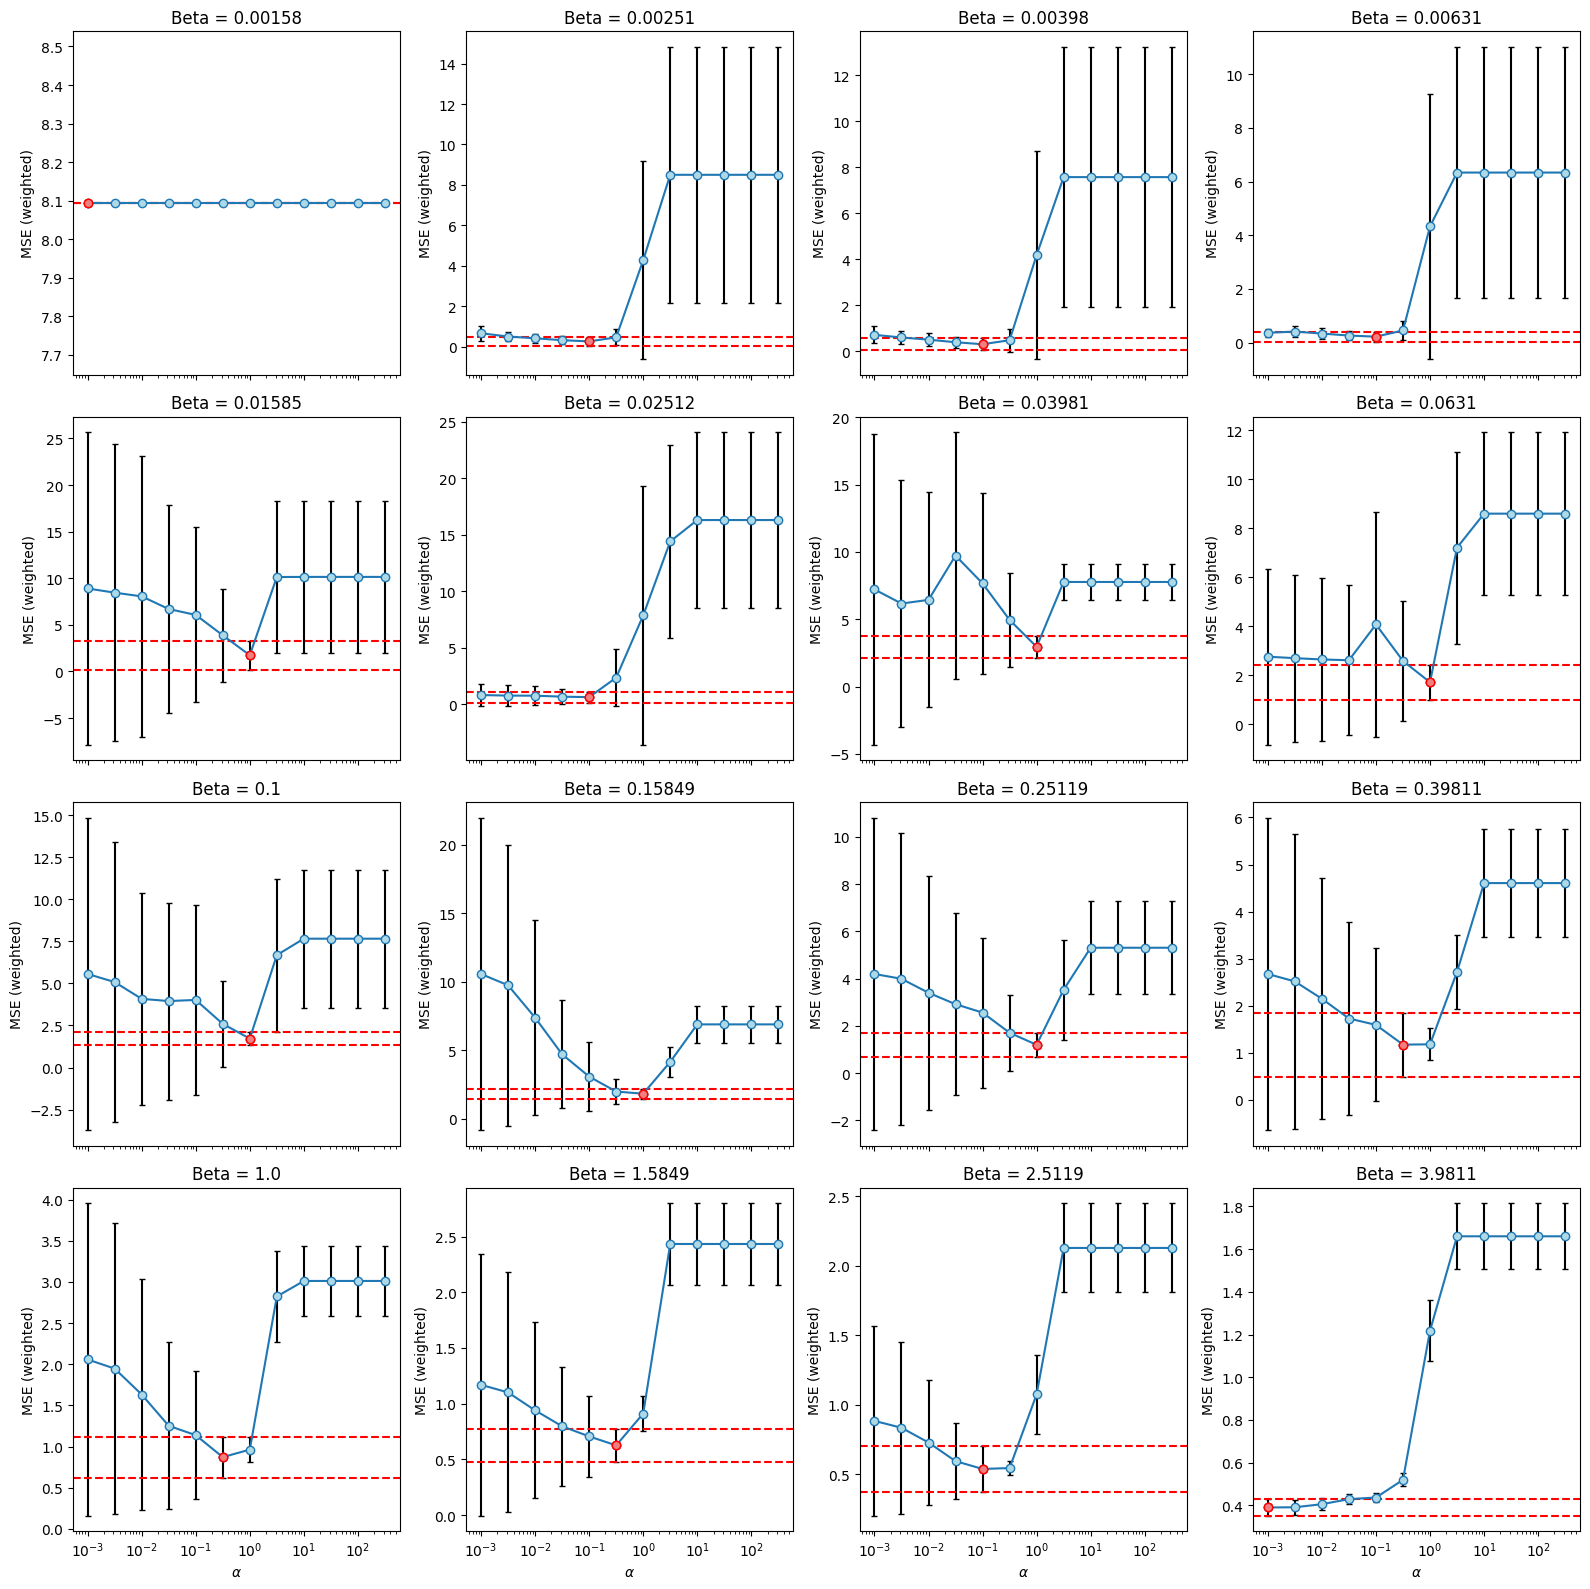

In [58]:
fig, axs = plt.subplots(4,4, figsize=(16,16), sharex='all')
axs = [ax for axlist in axs for ax in axlist]

for j,beta in enumerate(cv_results.keys()):
    cv_results[beta].plot(x='alpha', y='mean_score', yerr='std_score', 
                marker='o', markerfacecolor='lightblue', ecolor='black', capsize=2, 
                legend=False, ax=axs[j])

    idx_best = np.argmin(cv_results[beta]['mean_score'])
    best_alpha = cv_results[beta].iloc[idx_best]['alpha']
    best_score = cv_results[beta].iloc[idx_best]['mean_score']
    best_std = cv_results[beta].iloc[idx_best]['std_score']
    axs[j].plot([best_alpha, best_alpha],[best_score, best_score], 'o', markerfacecolor='lightcoral', markeredgecolor='red', zorder=3)
    axs[j].axhline(best_score + best_std, ls='--', color='red')
    axs[j].axhline(best_score - best_std, ls='--', color='red')

    axs[j].set_xscale('log')
    axs[j].set_xlabel(r'$\alpha$')
    axs[j].set_ylabel('MSE (weighted)')
    axs[j].set_title(f'Beta = {round(beta, 5)}')

fig.tight_layout()

In [62]:
cv_results[3.9811]

,alpha,mean_score,std_score
0,0.001000,0.389867,0.037664
1,0.003162,0.390874,0.035162
2,0.010000,0.405274,0.028521
3,0.031623,0.428858,0.023984
4,0.100000,0.436498,0.021023
5,0.316228,0.519263,0.030086
6,1.000000,1.217891,0.142739
7,3.162278,1.659955,0.153985
8,10.000000,1.659955,0.153985
9,31.622777,1.659955,0.153985


Comentarios:

1. Obviamente para $\beta$ bajos que tienen muy pocos puntos de datos las estimaciones del error y los fits del modelo y demás son no demasiado fiables

2. En algunos casos tenemos una curva similar a la que encontrabamos con $\beta$ como predictor donde mantenemos error bajo hasta subir demasiado la regularización y entonces saltamos a error muy alto (osea que el modelo practicamente siempre está en underfitting)

3. En otro sin embargo parece que hay un régimen de overfitting donde si no penalizas suficiente el error es más alto.

Como en este caso no estamos seleccionando cuidadosamente un modelo sino 16 a la vez para luego predecir sus coeficientes, no voy a hacer una selección tan cuidadosa del $\alpha$ para cada uno.

En su lugar voy a coger el de error mínimo o como mucho el siguiente que tenga un error casi indiscernible del mínimo (en vez de considerar el límite del error estándar). Además voy a omitir al menos el caso de $\beta$ = 0.00158... porque solo tenía un punto y es totalmente insignificante

In [66]:
best_alpha = {
    betas[1]: 0.1, betas[2]: 0.1, betas[3]: 0.1, betas[4]: 1,
    betas[5]: 0.1, betas[6]: 1, betas[7]: 1, betas[8]: 1,
    betas[9]: 1, betas[10]: 1, betas[11]: 1, betas[12]: 0.316228, 
    betas[13]: 0.316228, betas[14]: 0.316228, betas[15]: 0.003162
}

db_models = {}
db_train_rmse = {}

for beta,alpha in best_alpha.items():
    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('lr', Lasso(alpha=alpha))])
    pipe.fit(db_Xtr[beta], db_ytr[beta], lr__sample_weight=db_wtr[beta])
    db_models[beta] = pipe
    yp = pipe.predict(db_Xtr[beta])
    db_train_rmse[beta] = np.sqrt(mean_squared_error(db_ytr[beta], yp, sample_weight=db_wtr[beta]))


/home/kiaran/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.034e-02, tolerance: 9.415e-03
  model = cd_fast.enet_coordinate_descent(


***Estudio de resultados y evolución del modelo***

Text(0, 0.5, 'Train RMSE')

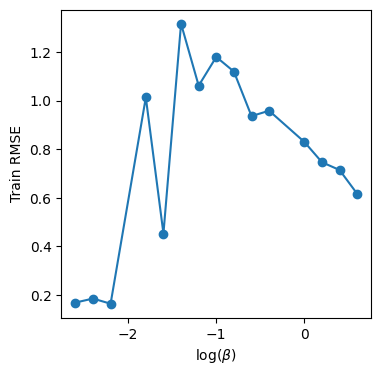

In [79]:
plt.figure(figsize=(4,4))
logbeta = np.log10(np.array(list(db_train_rmse.keys())))
rmse = np.array(list(db_train_rmse.values()))
plt.plot(logbeta, rmse, 'o-')
plt.xlabel(r'log($\beta$)')
plt.ylabel('Train RMSE')

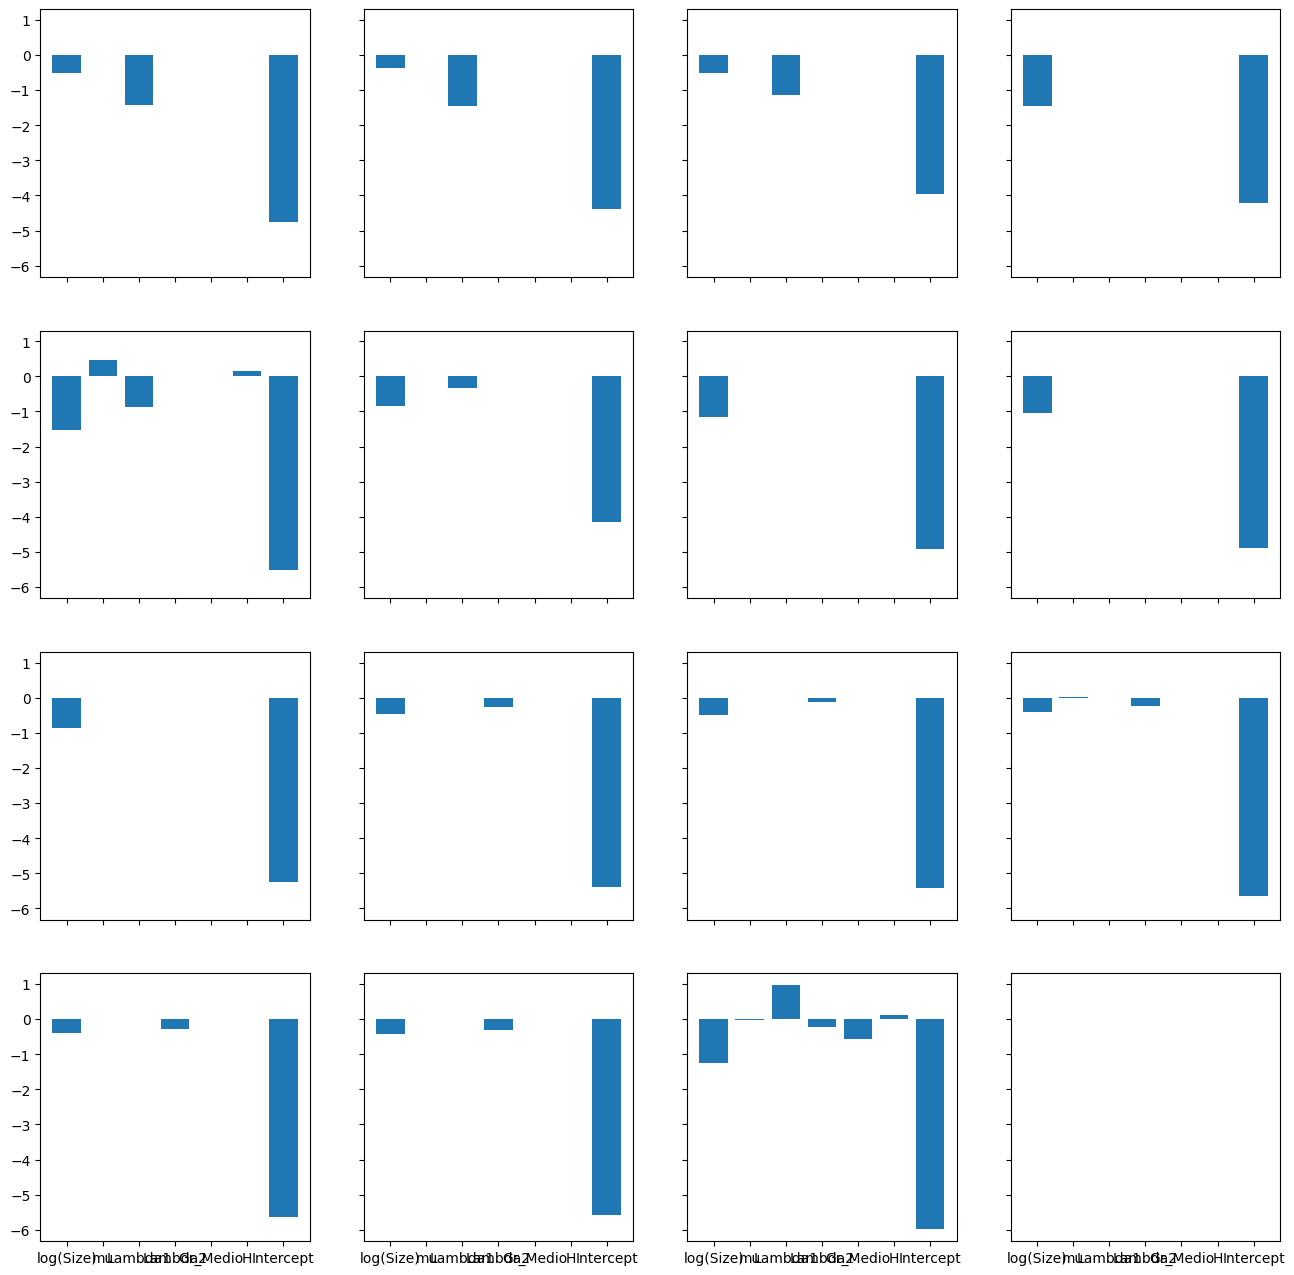

In [98]:
fig, axs = plt.subplots(4,4, figsize=(16,16), sharex='all', sharey='all')
axs = [ax for axlist in axs for ax in axlist]

for j,beta in enumerate(db_models.keys()):
    coefs = np.append(db_models[beta]['lr'].coef_, db_models[beta]['lr'].intercept_)
    vars = list(db_Xtr[beta].columns)
    vars.append('Intercept')
    axs[j].bar(x=vars, height=coefs)